In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time as timeit
import pdb

In [2]:
def K(p):
    return p.T.dot(p)/2

def dK(p):
    return p

def U(q):
    q1 = q[0]
    q2 = q[1]
    return .5*(q1**2 + q2**2) + q2*q1**2 - (1/3.)*q2**3

def dU(q):
    q1 = q[0]
    q2 = q[1]
    x1 = q1 + 2*q1*q2
    x2 = q1**2 + q2 - q2**2
    return np.array([[x1],[x2]]).reshape(2,1)

def H(p,q):
    return K(p) + U(q)

#t = np.array([[2],[3]])
#T(t)
#U(t)
#dU(t)
#H(t,t)

In [3]:
Dim = 2
M = np.identity(Dim)
Minv = np.linalg.inv(M)
p0 = np.array([[-.28],[.23]]).reshape(2,1)
q0 = np.array([[.23],[-.28]]).reshape(2,1)
H0 = np.squeeze(H(p0,q0))
print(f'Initial energy: {H0}')

Initial energy: 0.12380533333333335


### Monitor Functions ($G$)
In general for function $G$,
$$G(\mathbf{y}) = -\frac{1}{\sigma(\mathbf{y})}\nabla\sigma(\mathbf{y})^{\top}f(\mathbf{y}),$$
where $\mathbf{y}$ can be $\mathbf{y}=(\mathbf{p},\mathbf{q})$ or just $\mathbf{q}$ depending on the design of $\sigma$.

**Sa. ($\sigma_a$)**<br>
$\sigma_a(\mathbf{q}) =\left((H_0-U(\mathbf{q})) + \nabla U(\mathbf{q})^{\top}\mathbf{M}^{-1}\,\nabla U(\mathbf{q})\right)^{-\frac{1}{2}} $<br>
<br>
**Sb. ($\sigma_b$)**<br>
$\sigma_b (\mathbf{q}) = (H_0 - U(\mathbf{q}))^{-\frac{1}{2}}$ <br>

**Sc. ($\sigma_c$)**<br>
$\sigma_c(\mathbf{q}) = \lvert|\mathbf{q}\rvert|^{\alpha}$, where $\alpha = 2$.

**Sd. ($\sigma_d$)**<br>
$(\mathbf{q}^{\top}\mathbf{q})^{\alpha}$, where $\alpha=\frac{3}{2}$

**Se. ($\sigma_e$)**<br>
$(\mathbf{q}^{\top}\mathbf{q})^{\alpha}$, where $\alpha=\frac{1}{2}$

*Note: Sa and Sb function had issues with negative values under the square root (white regions of sigma plots).Errors are thrown upon hitting these regions, stopping the integration. The values of $\sigma_b$ explode after about 10 steps. Trajectories begin in the lower left corner and this explosion of values corresponded to hitting a wall of the potential (first compression of points for $\sigma_a$). It seems the value of $U$ must remain below $H_0$. Sa is possibly more forgiving since there is a gradient term under the radical.*

*Note: Sc, Sd, Se do not take into account the topology of the potential. They have a circular topology.*

In [4]:
def Sa(q,h0):
    uq = U(q)*.6 # Multiplying by .6 removes negative under radical
    duq = dU(q)
    return (1/np.sqrt((h0-uq) + np.dot(duq.T, np.dot(Minv,duq))))[0,0]
#Sa(q0,H0)

def dSa(q):
    q1 = q[0,0]
    q2 = q[1,0]
    qx = -q1 + 2*q1*q2 + 2*(1+2*q2)*(q1+2*q1*q2) + 4*q1*(q1**2+q2-q2**2)
    qy = q1**2 - q2 - q2**2 + 4*q1*(q1+2*q1*q2) +  2*(1-2*q2)*(q1**2+q2-q2**2)
    return np.array([[qx],[qy]])

In [5]:
def Sb(q,h0):
    return 1/np.sqrt(h0 - .1*U(q))

def dSb(q,h0):
    return (.5*Sb(q,h0)**3)*dU(q)

In [6]:
def Sc(q):
    return np.dot(q.T,q)[0,0]

def dSc(q):
    return 2*q

In [7]:
def Sd(q):
    return (np.sqrt(np.dot(q.T,q))**3)[0,0]

def dSd(q):
    return 3.*np.sqrt(np.dot(q.T,q))*q

In [8]:
def Se(q):
    return ((np.dot(q.T,q))**(1/4))[0,0]

def dSe(q):
    return (1/Se(q)**3)*q

In [9]:
def Ga(p,q,h0):
    return (-1/Sa(q,h0))*np.dot(dSa(q).T,p)

def Gb(p,q,h0):
    return (-1/Sb(q,h0))*np.dot(dSb(q,h0).T,p)

def Gc(p,q,h0):
    return (-1/Sc(q))*np.dot(dSc(q).T,p)

def Gd(p,q, h0=None):
    return (-1/Sd(q))*np.dot(dSd(q).T,p)

def Ge(p,q, h0=None):
    return (-1/Se(q))*np.dot(dSe(q).T,p)

In [10]:
def sv(p, q, h, time):
    
    steps = int(time//h)
    position = np.zeros((2,steps))
    start = timeit()
    for i in range(steps):
        p -= (h/2.)*dU(q)
        q += h*p
        p -= (h/2.)*dU(q)
        position[:,i] = np.squeeze(q)
    print(f'sv runtime={timeit()-start}')
    return position

In [11]:
def VSV(G,p,q,h0,h,time):
    
    position = []
    energy = []
    cerr = []
    ssz = []
    totalSteps = 0.
    start = timeit()
    z = 1 - (h/2.)*G(p,q,h0)
    Z0 = z
    #Q0 = Q(q,h0)
    while(totalSteps < time):
        z = z + h*G(p,q,h0)
        p = p - .5*h*dU(q)/z
        q = q + h*dK(p)/z
        p = p - .5*h*dU(q)/z
        ssz.append(np.squeeze(h/z - h/Z0).tolist())
        totalSteps += h/z
        #cerr.append(np.abs(-Z0/Q0 + z/Q(q,h0)))
        energy.append(np.abs(np.squeeze(H(p,q)-h0)).tolist())
        position.append(np.squeeze(q).tolist())
        print(q)
    print(f'vsv runtime={timeit()-start}')
    return position, energy, ssz, cerr

In [12]:
h = 1e-1
Time = 20
#### Starting points


p0 = np.array([[-.3],[.31]]).reshape(2,1)
q0 = np.array([[-.6],[-.5]]).reshape(2,1)
Q2 = sv(p0,q0,h, Time)



p0 = np.array([[-.3],[.31]]).reshape(2,1)
q0 = np.array([[-.6],[-.5]]).reshape(2,1)
Qa, Es, _, _ = VSV(Ga,p0,q0,H0,h,Time)
Qa = np.array(Qa).T

p0 = np.array([[-.3],[.31]]).reshape(2,1)
q0 = np.array([[-.6],[-.5]]).reshape(2,1)
Qb, Es, _, _ = VSV(Gb,p0,q0,H0,h,Time)
Qb = np.array(Qb).T

p0 = np.array([[-.3],[.31]]).reshape(2,1)
q0 = np.array([[-.6],[-.5]]).reshape(2,1)
Qc, Es, _, _ = VSV(Gc,p0,q0,H0,h,Time)
Qc = np.array(Qc).T

p0 = np.array([[-.3],[.31]]).reshape(2,1)
q0 = np.array([[-.6],[-.5]]).reshape(2,1)
Qd, Es, _, _ = VSV(Gd,p0,q0,H0,h,Time)
Qd = np.array(Qd).T


p0 = np.array([[-.3],[.31]]).reshape(2,1)
q0 = np.array([[-.6],[-.5]]).reshape(2,1)
Qe, Es, _, _ = VSV(Ge,p0,q0,H0,h,Time)
Qe = np.array(Qe).T

sv runtime=0.006815910339355469
[[-0.62942291]
 [-0.46772063]]
[[-0.65778824]
 [-0.43349105]]
[[-0.68504879]
 [-0.39793792]]
[[-0.71099369]
 [-0.3616912 ]]
[[-0.73531642]
 [-0.3253518 ]]
[[-0.75766868]
 [-0.28941476]]
[[-0.77760952]
 [-0.25429605]]
[[-0.79445608]
 [-0.22047797]]
[[-0.80706543]
 [-0.18874801]]
[[-0.81361794]
 [-0.16049278]]
[[-0.8116657 ]
 [-0.13784572]]
[[-0.79892859]
 [-0.12318996]]
[[-0.77471631]
 [-0.11783821]]
[[-0.74041357]
 [-0.12114856]]
[[-0.69828974]
 [-0.13120242]]
[[-0.65021067]
 [-0.1459741 ]]
[[-0.59728066]
 [-0.16384783]]
[[-0.54004661]
 [-0.18358468]]
[[-0.47878295]
 [-0.20413914]]
[[-0.41367247]
 [-0.2245176 ]]
[[-0.34486945]
 [-0.24371383]]
[[-0.27252677]
 [-0.26068894]]
[[-0.19688688]
 [-0.27437178]]
[[-0.1184487 ]
 [-0.28371094]]
[[-0.03811225]
 [-0.28782594]]
[[ 0.04284204]
 [-0.28623268]]
[[ 0.12299721]
 [-0.27900887]]
[[ 0.20113383]
 [-0.26676587]]
[[ 0.27643055]
 [-0.25045052]]
[[ 0.3484395 ]
 [-0.23112906]]
[[ 0.41692631]
 [-0.20986412]]
[[ 0.48

 [-0.27756479]]
[[ 0.14114452]
 [-0.27621966]]
[[ 0.15138134]
 [-0.2747614 ]]
[[ 0.1618422]
 [-0.2731825]]
[[ 0.17254838]
 [-0.27147456]]
[[ 0.18352274]
 [-0.26962821]]
[[ 0.19478985]
 [-0.26763302]]
[[ 0.20637616]
 [-0.26547734]]
[[ 0.21831026]
 [-0.26314823]]
[[ 0.23062307]
 [-0.26063128]]
[[ 0.24334811]
 [-0.25791043]]
[[ 0.25652171]
 [-0.25496789]]
[[ 0.27018331]
 [-0.25178384]]
[[ 0.28437575]
 [-0.24833637]]
[[ 0.29914545]
 [-0.24460123]]
[[ 0.31454271]
 [-0.24055172]]
[[ 0.33062182]
 [-0.23615855]]
[[ 0.34744114]
 [-0.23138987]]
[[ 0.36506289]
 [-0.22621138]]
[[ 0.38355279]
 [-0.22058668]]
[[ 0.40297907]
 [-0.21447802]]
[[ 0.4234109 ]
 [-0.20784755]]
[[ 0.44491574]
 [-0.2006595 ]]
[[ 0.46755509]
 [-0.19288351]]
[[ 0.49137815]
 [-0.18449985]]
[[ 0.51641228]
 [-0.17550716]]
[[ 0.54264919]
 [-0.16593377]]
[[ 0.57002564]
 [-0.1558537 ]]
[[ 0.59839717]
 [-0.14540833]]
[[ 0.62750458]
 [-0.13483435]]
[[ 0.6569343 ]
 [-0.12449649]]
[[ 0.68607802]
 [-0.11492068]]
[[ 0.71410292]
 [-0.10681

 [-0.26214916]]
[[ 0.26804389]
 [-0.27515531]]
[[ 0.27554418]
 [-0.28902486]]
[[ 0.28357628]
 [-0.30381974]]
[[ 0.2921937 ]
 [-0.31960015]]
[[ 0.30145648]
 [-0.33642097]]
[[ 0.31143212]
 [-0.35432618]]
[[ 0.32219666]
 [-0.37334094]]
[[ 0.33383601]
 [-0.39346017]]
[[ 0.34644757]
 [-0.41463296]]
[[ 0.36014212]
 [-0.43674146]]
[[ 0.3750461]
 [-0.459574 ]]
[[ 0.39130419]
 [-0.48279254]]
[[ 0.40908178]
 [-0.50589698]]
[[ 0.4285668 ]
 [-0.52819218]]
[[ 0.4499693 ]
 [-0.54876844]]
[[ 0.47351692]
 [-0.56651094]]
[[ 0.49944348]
 [-0.58015552]]
[[ 0.52796909]
 [-0.58840156]]
[[ 0.55927247]
 [-0.59007535]]
[[ 0.59345997]
 [-0.58431235]]
[[ 0.63053843]
 [-0.57070918]]
[[ 0.67039657]
 [-0.54940374]]
[[ 0.71279069]
 [-0.52107694]]
[[ 0.75731887]
 [-0.48691512]]
[[ 0.80335923]
 [-0.44859894]]
[[ 0.84994984]
 [-0.40837738]]
[[ 0.89560989]
 [-0.36923938]]
[[ 0.9381587 ]
 [-0.33510523]]
[[ 0.97469091]
 [-0.31082705]]
[[ 1.00195476]
 [-0.30168849]]
[[ 1.01727146]
 [-0.31224949]]
[[ 1.01968251]
 [-0.34494

 [-0.09943109]]
[[-0.01811884]
 [-0.0992956 ]]
[[-0.01819217]
 [-0.09916058]]
[[-0.01826523]
 [-0.09902603]]
[[-0.01833804]
 [-0.09889196]]
[[-0.01841059]
 [-0.09875835]]
[[-0.01848288]
 [-0.09862521]]
[[-0.01855492]
 [-0.09849253]]
[[-0.01862671]
 [-0.09836031]]
[[-0.01869825]
 [-0.09822855]]
[[-0.01876954]
 [-0.09809723]]
[[-0.01884058]
 [-0.09796637]]
[[-0.01891138]
 [-0.09783595]]
[[-0.01898193]
 [-0.09770598]]
[[-0.01905224]
 [-0.09757645]]
[[-0.0191223 ]
 [-0.09744735]]
[[-0.01919213]
 [-0.09731869]]
[[-0.01926172]
 [-0.09719047]]
[[-0.01933108]
 [-0.09706267]]
[[-0.0194002]
 [-0.0969353]]
[[-0.01946908]
 [-0.09680836]]
[[-0.01953774]
 [-0.09668184]]
[[-0.01960616]
 [-0.09655573]]
[[-0.01967435]
 [-0.09643005]]
[[-0.01974232]
 [-0.09630477]]
[[-0.01981006]
 [-0.09617991]]
[[-0.01987758]
 [-0.09605546]]
[[-0.01994487]
 [-0.09593141]]
[[-0.02001194]
 [-0.09580777]]
[[-0.02007879]
 [-0.09568453]]
[[-0.02014542]
 [-0.09556169]]
[[-0.02021184]
 [-0.09543924]]
[[-0.02027804]
 [-0.09531

 [-0.05098865]]
[[-0.04416741]
 [-0.05094792]]
[[-0.04418917]
 [-0.05090722]]
[[-0.04421091]
 [-0.05086655]]
[[-0.04423264]
 [-0.05082591]]
[[-0.04425435]
 [-0.0507853 ]]
[[-0.04427605]
 [-0.05074471]]
[[-0.04429772]
 [-0.05070416]]
[[-0.04431939]
 [-0.05066363]]
[[-0.04434103]
 [-0.05062314]]
[[-0.04436267]
 [-0.05058267]]
[[-0.04438428]
 [-0.05054223]]
[[-0.04440588]
 [-0.05050183]]
[[-0.04442747]
 [-0.05046145]]
[[-0.04444904]
 [-0.05042109]]
[[-0.04447059]
 [-0.05038077]]
[[-0.04449213]
 [-0.05034048]]
[[-0.04451365]
 [-0.05030021]]
[[-0.04453515]
 [-0.05025998]]
[[-0.04455665]
 [-0.05021977]]
[[-0.04457812]
 [-0.05017959]]
[[-0.04459958]
 [-0.05013943]]
[[-0.04462103]
 [-0.05009931]]
[[-0.04464246]
 [-0.05005921]]
[[-0.04466387]
 [-0.05001914]]
[[-0.04468527]
 [-0.0499791 ]]
[[-0.04470666]
 [-0.04993909]]
[[-0.04472803]
 [-0.0498991 ]]
[[-0.04474938]
 [-0.04985914]]
[[-0.04477072]
 [-0.04981921]]
[[-0.04479205]
 [-0.04977931]]
[[-0.04481336]
 [-0.04973943]]
[[-0.04483465]
 [-0.049

 [-0.02553912]]
[[-0.05771515]
 [-0.02550567]]
[[-0.05773289]
 [-0.02547222]]
[[-0.05775064]
 [-0.02543877]]
[[-0.05776838]
 [-0.02540531]]
[[-0.05778613]
 [-0.02537185]]
[[-0.05780388]
 [-0.02533838]]
[[-0.05782163]
 [-0.02530491]]
[[-0.05783938]
 [-0.02527143]]
[[-0.05785714]
 [-0.02523795]]
[[-0.0578749 ]
 [-0.02520447]]
[[-0.05789266]
 [-0.02517098]]
[[-0.05791042]
 [-0.02513748]]
[[-0.05792819]
 [-0.02510398]]
[[-0.05794595]
 [-0.02507048]]
[[-0.05796372]
 [-0.02503697]]
[[-0.0579815 ]
 [-0.02500346]]
[[-0.05799927]
 [-0.02496994]]
[[-0.05801705]
 [-0.02493641]]
[[-0.05803483]
 [-0.02490288]]
[[-0.05805261]
 [-0.02486935]]
[[-0.05807039]
 [-0.02483581]]
[[-0.05808818]
 [-0.02480227]]
[[-0.05810597]
 [-0.02476872]]
[[-0.05812376]
 [-0.02473516]]
[[-0.05814156]
 [-0.0247016 ]]
[[-0.05815936]
 [-0.02466804]]
[[-0.05817716]
 [-0.02463447]]
[[-0.05819496]
 [-0.02460089]]
[[-0.05821277]
 [-0.02456731]]
[[-0.05823057]
 [-0.02453372]]
[[-0.05824838]
 [-0.02450013]]
[[-0.0582662 ]
 [-0.024

 [-0.00044919]]
[[-0.07097724]
 [-0.00040158]]
[[-0.07100231]
 [-0.00035392]]
[[-0.07102741]
 [-0.00030622]]
[[-0.07105254]
 [-0.00025846]]
[[-0.07107769]
 [-0.00021065]]
[[-0.07110287]
 [-0.0001628 ]]
[[-0.07112808]
 [-0.00011489]]
[[-7.11533120e-02]
 [-6.69286258e-05]]
[[-7.11785708e-02]
 [-1.89184820e-05]]
[[-7.12038561e-02]
 [ 2.91427724e-05]]
[[-7.12291679e-02]
 [ 7.72552930e-05]]
[[-0.07125451]
 [ 0.00012542]]
[[-0.07127987]
 [ 0.00017363]]
[[-0.07130526]
 [ 0.0002219 ]]
[[-0.07133068]
 [ 0.00027022]]
[[-0.07135613]
 [ 0.00031859]]
[[-0.0713816 ]
 [ 0.00036702]]
[[-0.0714071 ]
 [ 0.00041549]]
[[-0.07143263]
 [ 0.00046402]]
[[-0.07145818]
 [ 0.0005126 ]]
[[-0.07148377]
 [ 0.00056123]]
[[-0.07150938]
 [ 0.00060992]]
[[-0.07153501]
 [ 0.00065866]]
[[-0.07156068]
 [ 0.00070746]]
[[-0.07158637]
 [ 0.0007563 ]]
[[-0.07161209]
 [ 0.0008052 ]]
[[-0.07163784]
 [ 0.00085416]]
[[-0.07166362]
 [ 0.00090317]]
[[-0.07168942]
 [ 0.00095223]]
[[-0.07171525]
 [ 0.00100134]]
[[-0.07174111]
 [ 0.00

 [ 0.06669712]]
[[-0.10601403]
 [ 0.06695719]]
[[-0.10614843]
 [ 0.06721883]]
[[-0.10628362]
 [ 0.06748204]]
[[-0.10641962]
 [ 0.06774685]]
[[-0.10655644]
 [ 0.06801328]]
[[-0.10669408]
 [ 0.06828133]]
[[-0.10683255]
 [ 0.06855104]]
[[-0.10697186]
 [ 0.06882242]]
[[-0.10711202]
 [ 0.06909548]]
[[-0.10725304]
 [ 0.06937024]]
[[-0.10739493]
 [ 0.06964673]]
[[-0.1075377 ]
 [ 0.06992497]]
[[-0.10768136]
 [ 0.07020496]]
[[-0.10782591]
 [ 0.07048673]]
[[-0.10797137]
 [ 0.07077031]]
[[-0.10811775]
 [ 0.07105571]]
[[-0.10826505]
 [ 0.07134295]]
[[-0.1084133 ]
 [ 0.07163206]]
[[-0.10856249]
 [ 0.07192305]]
[[-0.10871264]
 [ 0.07221595]]
[[-0.10886376]
 [ 0.07251077]]
[[-0.10901587]
 [ 0.07280755]]
[[-0.10916897]
 [ 0.0731063 ]]
[[-0.10932307]
 [ 0.07340705]]
[[-0.10947818]
 [ 0.07370982]]
[[-0.10963433]
 [ 0.07401463]]
[[-0.10979151]
 [ 0.07432151]]
[[-0.10994975]
 [ 0.07463049]]
[[-0.11010905]
 [ 0.07494158]]
[[-0.11026943]
 [ 0.07525482]]
[[-0.1104309 ]
 [ 0.07557022]]
[[-0.11059347]
 [ 0.075

 [-0.02791682]]
[[ 0.19988683]
 [-0.02897134]]
[[ 0.20045042]
 [-0.03003703]]
[[ 0.20101946]
 [-0.03111414]]
[[ 0.20159408]
 [-0.03220295]]
[[ 0.2021744 ]
 [-0.03330374]]
[[ 0.20276055]
 [-0.03441679]]
[[ 0.20335269]
 [-0.0355424 ]]
[[ 0.20395093]
 [-0.03668088]]
[[ 0.20455543]
 [-0.03783254]]
[[ 0.20516635]
 [-0.03899771]]
[[ 0.20578382]
 [-0.04017673]]
[[ 0.20640803]
 [-0.04136995]]
[[ 0.20703912]
 [-0.04257774]]
[[ 0.20767727]
 [-0.04380046]]
[[ 0.20832266]
 [-0.04503851]]
[[ 0.20897547]
 [-0.04629228]]
[[ 0.20963589]
 [-0.0475622 ]]
[[ 0.21030412]
 [-0.0488487 ]]
[[ 0.21098035]
 [-0.05015222]]
[[ 0.2116648 ]
 [-0.05147322]]
[[ 0.21235769]
 [-0.0528122 ]]
[[ 0.21305923]
 [-0.05416964]]
[[ 0.21376967]
 [-0.05554607]]
[[ 0.21448924]
 [-0.05694203]]
[[ 0.2152182 ]
 [-0.05835807]]
[[ 0.21595681]
 [-0.05979478]]
[[ 0.21670534]
 [-0.06125277]]
[[ 0.21746407]
 [-0.06273266]]
[[ 0.2182333 ]
 [-0.06423512]]
[[ 0.21901332]
 [-0.06576082]]
[[ 0.21980445]
 [-0.06731048]]
[[ 0.22060704]
 [-0.068

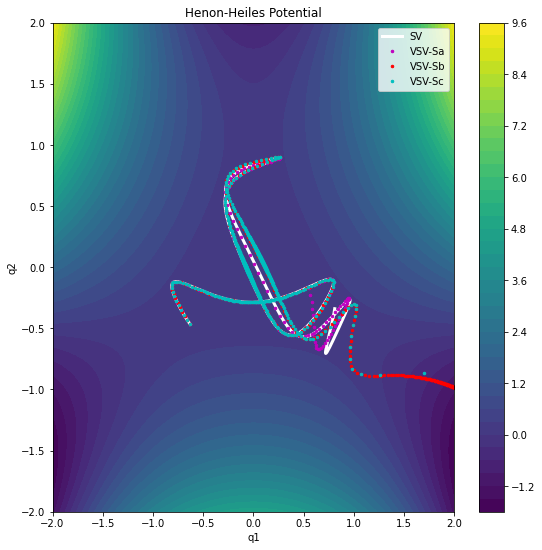

In [13]:
bnd = 2
xlist = np.linspace(-bnd, bnd, 1000)
ylist = np.linspace(-bnd, bnd, 1000)
X, Y = np.meshgrid(xlist, ylist)
Z = .5*(X**2 + Y**2) + Y*X**2 - (1/3.)*Y**3
fig,ax=plt.subplots(1,1, figsize=(9,9))
cp = ax.contourf(X, Y, Z, levels=40)
ms = 5
ax.plot(Q2[0,:],Q2[1,:],'white', markersize=20, linewidth=3, label='SV')
ax.plot(Qa[0,:],Qa[1,:],'m.', markersize=ms, label='VSV-Sa')
ax.plot(Qb[0,:],Qb[1,:],'r.', markersize=ms, label='VSV-Sb')
ax.plot(Qc[0,:],Qc[1,:],'c.', markersize=ms, label='VSV-Sc')
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_title('Henon-Heiles Potential')
ax.set_xlabel('q1')
ax.set_ylabel('q2')
plt.legend()
plt.show()

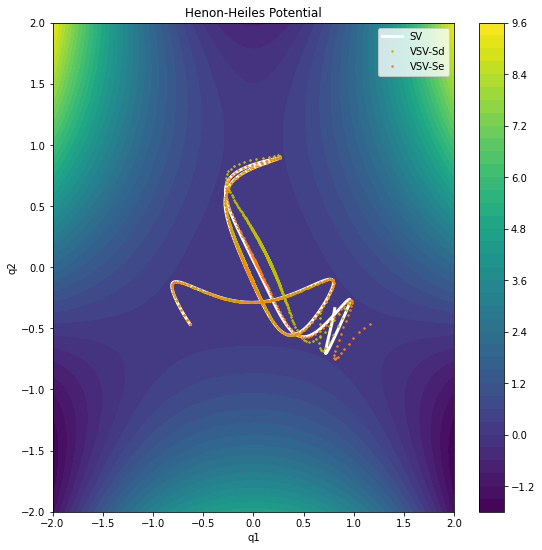

In [14]:
bnd = 2
xlist = np.linspace(-bnd, bnd, 1000)
ylist = np.linspace(-bnd, bnd, 1000)
X, Y = np.meshgrid(xlist, ylist)
Z = .5*(X**2 + Y**2) + Y*X**2 - (1/3.)*Y**3
fig,ax=plt.subplots(1,1, figsize=(9,9))
cp = ax.contourf(X, Y, Z, levels=40)
ms = 3
ax.plot(Q2[0,:],Q2[1,:],'white', markersize=20, linewidth=3, label='SV')
ax.plot(Qd[0,:],Qd[1,:],'y.', markersize=ms, label='VSV-Sd')
ax.plot(Qe[0,:],Qe[1,:],'.', color='tab:orange', markersize=ms, label='VSV-Se')
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Henon-Heiles Potential')
ax.set_xlabel('q1')
ax.set_ylabel('q2')
plt.legend()
plt.show()

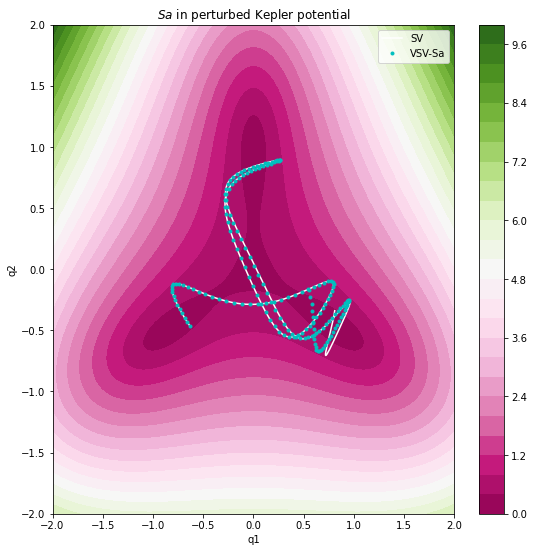

In [15]:
def Uc(qx,qy):
    return .5*(qx**2+qy**2) + qx**2*qy - (qy**3)/3

def dUc2(qx,qy):
    return (qx+2*qx*qy)**2 + (qx**2+qy-qy**2)**2

def Sac(X, Y, h0):
    return np.sqrt(h0 - Uc(X,Y)*.6 + dUc2(X,Y))

bnd = 2.
xlist = np.linspace(-bnd, bnd, 500)
ylist = np.linspace(-bnd, bnd, 500)
X, Y = np.meshgrid(xlist, ylist)
Z = Sac(X,Y,H0)

fig,ax=plt.subplots(1,1, figsize=(9,9))
cp = ax.contourf(X, Y, Z, levels=30, cmap ='PiYG')
ax.plot(Q2[0,:],Q2[1,:],'white', label='SV')
ax.plot(Qa[0,:],Qa[1,:],'c.', label='VSV-Sa')
ax.set_xlim(-bnd,bnd)
ax.set_ylim(-bnd,bnd)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('$Sa$ in perturbed Kepler potential')
ax.set_xlabel('q1')
ax.set_ylabel('q2')
plt.legend()
plt.show()

/tmp/ipykernel_55728/1293269569.py:2: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(h0 - .1*Uc(X,Y))


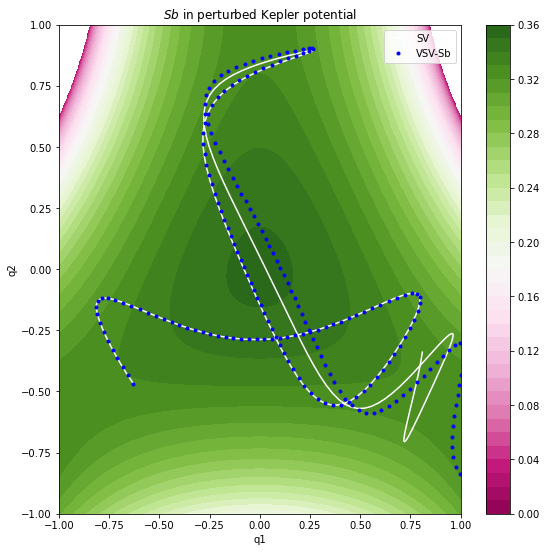

In [22]:
def Sbc(X,Y, h0):
    return np.sqrt(h0 - .1*Uc(X,Y))

bnd = 1.
xlist = np.linspace(-bnd, bnd, 500)
ylist = np.linspace(-bnd, bnd, 500)
X, Y = np.meshgrid(xlist, ylist)
Z = Sbc(X,Y,H0)

fig,ax=plt.subplots(1,1, figsize=(9,9))
cp = ax.contourf(X, Y, Z, levels=40, cmap ='PiYG')
ax.plot(Q2[0,:],Q2[1,:],'white', label='SV')
ax.plot(Qb[0,:],Qb[1,:],'b.', label='VSV-Sb')
ax.set_xlim(-bnd,bnd)
ax.set_ylim(-bnd,bnd)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('$Sb$ in perturbed Kepler potential')
ax.set_xlabel('q1')
ax.set_ylabel('q2')
plt.legend()
plt.show()

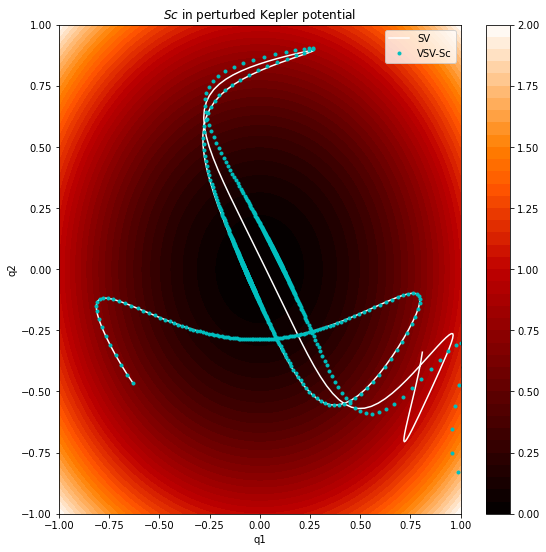

In [28]:
def Scc(x,y):
    return X**2 + Y**2

bnd = 1.
xlist = np.linspace(-bnd, bnd, 500)
ylist = np.linspace(-bnd, bnd, 500)
X, Y = np.meshgrid(xlist, ylist)
Z = Scc(X,Y)

fig,ax=plt.subplots(1,1, figsize=(9,9))
cp = ax.contourf(X, Y, Z, levels=40, cmap ='gist_heat')
ax.plot(Q2[0,:],Q2[1,:],'white', label='SV')
ax.plot(Qc[0,:],Qc[1,:],'c.', label='VSV-Sc')
ax.set_xlim(-bnd,bnd)
ax.set_ylim(-bnd,bnd)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('$Sc$ in perturbed Kepler potential')
ax.set_xlabel('q1')
ax.set_ylabel('q2')
plt.legend()
plt.show()

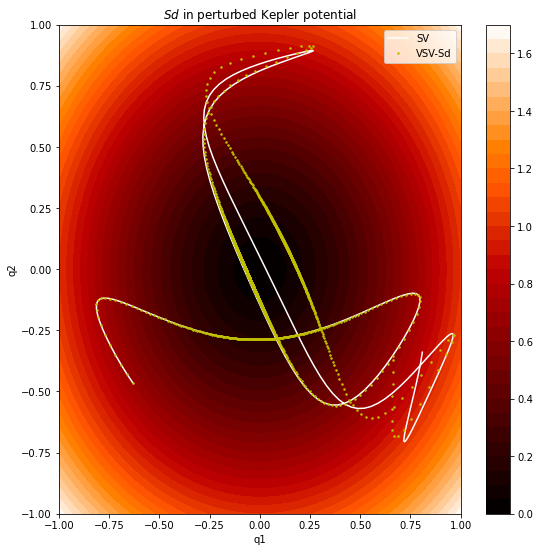

In [26]:
def Sdc(x,y):
    return (X**2 + Y**2)**(3/4)

bnd = 1.
xlist = np.linspace(-bnd, bnd, 500)
ylist = np.linspace(-bnd, bnd, 500)
X, Y = np.meshgrid(xlist, ylist)
Z = Sdc(X,Y)

fig,ax=plt.subplots(1,1, figsize=(9,9))
cp = ax.contourf(X, Y, Z, levels=40, cmap ='gist_heat')
ax.plot(Q2[0,:],Q2[1,:],'white', label='SV')
ax.plot(Qd[0,:],Qd[1,:],'y.', markersize=ms, label='VSV-Sd')
ax.set_xlim(-bnd,bnd)
ax.set_ylim(-bnd,bnd)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('$Sd$ in perturbed Kepler potential')
ax.set_xlabel('q1')
ax.set_ylabel('q2')
plt.legend()
plt.show()

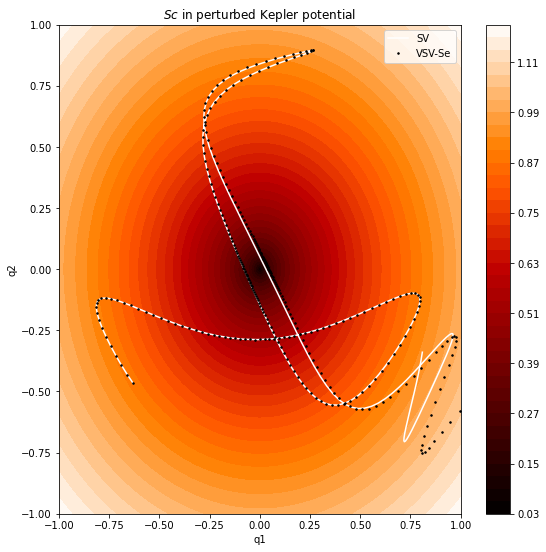

In [25]:
def Sec(x,y):
    return (X**2 + Y**2)**(1/4)

bnd = 1.
xlist = np.linspace(-bnd, bnd, 500)
ylist = np.linspace(-bnd, bnd, 500)
X, Y = np.meshgrid(xlist, ylist)
Z = Sec(X,Y)

fig,ax=plt.subplots(1,1, figsize=(9,9))
cp = ax.contourf(X, Y, Z, levels=40, cmap ='gist_heat')
ax.plot(Q2[0,:],Q2[1,:],'white', label='SV')
ax.plot(Qe[0,:],Qe[1,:],'.', color='k', markersize=ms, label='VSV-Se')
ax.set_xlim(-bnd,bnd)
ax.set_ylim(-bnd,bnd)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('$Sc$ in perturbed Kepler potential')
ax.set_xlabel('q1')
ax.set_ylabel('q2')
plt.legend()
plt.show()